# Defining Materials

We talk about how to modify built-in materials and define custom ones.

## Defining a custom material

Let's first look at the Material class itself

In [1]:
from granad import MaterialCatalog, Material, Rectangle
print(Material.__doc__)


    Represents a material in a simulation, encapsulating its physical properties and interactions.

    Attributes:
        name (str): The name of the material.
        species (dict): Dictionary mapping species names to their quantum numbers and associated atoms.
                        Each species is defined with properties like spin quantum number (s), and the atom type.
        orbitals (defaultdict[list]): A mapping from species to lists of orbitals. Each orbital is represented
                                      as a dictionary containing the orbital's position and an optional tag
                                      for further identification.
        interactions (defaultdict[dict]): Describes the interactions between orbitals within the material.
                                         Each interaction is categorized by type (e.g., 'hamiltonian', 'Coulomb'),
                                         and includes the participants, parameters like 
                        

The Material class offers all specialized functions to specify a material from a TB model. A preliminary, work-in-progress version of the Hubbard model would look like this

In [2]:
t = 1. # nearest-neighbor hopping
U = 0.1 # onsite coulomb repulsion
hubbard = (
    Material("Hubbard")
    .lattice_constant(1.0)
    .lattice_basis([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ])
    .add_orbital_species("up", s = -1)
    .add_orbital_species("down", s = 1)
    .add_orbital(position=(0, 0, 0), species = "up")
    .add_orbital(position=(0, 0, 0), species = "down")   
    .add_interaction(
        "hamiltonian",
        participants=("up", "up"),
        parameters=[0.0, t],
    )
    .add_interaction(
        "hamiltonian",
        participants=("down", "down"),
        parameters=[0.0, t],
    )
    .add_interaction(
        "coulomb",
        participants=("up", "down"),
        parameters=[U]
        )
)

To see how cutting finite flakes from this 3D material works, let's inspect

In [3]:
help(hubbard.cut_flake)

Help on method cut_flake in module granad.materials:

cut_flake() method of granad.materials.Material instance
    Finalizes the material construction by defining a method to cut a flake of the material,
    according to the material's dimensions like this

    1D material : materials.cut_flake_1d
    2D material : materials.cut_flake_2d
    3D material and higher : materials.cut_flake_generic

    This method is intended to be called after all material properties (like lattice constants,
    basis, orbitals, and interactions) have been fully defined.

    Note:
    This method does not take any parameters and does not return any value. Its effect is
    internal to the state of the Material object and is meant to prepare the material for
    simulation by implementing necessary final structural adjustments.



So, the cut_flake method is automatically determined. We have specified a 3D material, so let's look at the function that is applied

In [4]:
from granad.materials import cut_flake_generic
help(cut_flake_generic)

Help on function cut_flake_generic in module granad.materials:

cut_flake_generic(material, grid_range)
    Cuts a flake from the material using a specified grid range. This method is generic and can be applied
    to materials of any dimensionality.

    The function calculates the positions of orbitals within the unit cell, projects these onto the full
    lattice based on the provided grid range, and ensures that each position is unique. The result is a list
    of orbitals that are correctly positioned within the defined grid.

    Parameters:
        material (Material): The material instance from which to cut the flake.
        grid_range (list of tuples): Each tuple in the list specifies the range for the grid in that dimension.
                                     For example, [(0, 10), (0, 5)] defines a grid that extends from 0 to 10
                                     in the first dimension and from 0 to 5 in the second dimension.

    Returns:
        list: A list of orbita

Let's see this in action

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


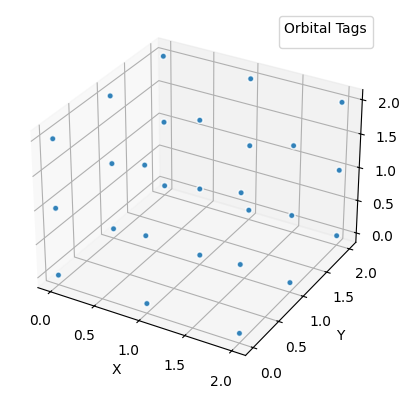

In [5]:
flake = hubbard.cut_flake( [(0,3), (0,3), (0,3)] ) # 3*3*3 = 27 unit cells, 3 in every direction, each hosting spin up and spin down atom
flake.show_3d()

## Direction-dependent couplings

Up to now, we have only considered couplings dependent on the scalar distance between two orbitals.
They can also be given as direction-dependent functions, like in Slater-Koster orbitals.
To this end, replace the neighbor coupling list by another list, where each entry specifies the coupling
as [d_x, d_y, d_z, coupling], where d_i are the distance vector components.
The example below illustrates this for a preliminary, work-in-progress version of the Haldane model of graphene.

In [6]:
import jax.numpy as jnp

delta, t1, t2 = 0.2, -2.66, 1j + 1    
haldane_graphene =  (
    Material("haldane_graphene")
    .lattice_constant(2.46)
    .lattice_basis([
        [1, 0, 0],
        [-0.5, jnp.sqrt(3)/2, 0]
    ])
    .add_orbital_species("pz1", atom='C')
    .add_orbital_species("pz2", atom='C')
    .add_orbital(position=(0, 0), tag="sublattice_1", species="pz1")
    .add_orbital(position=(-1/3, -2/3), tag="sublattice_2", species="pz2")
    .add_interaction(
        "hamiltonian",
        participants=("pz1", "pz2"),
        parameters= [t1],
    )
    .add_interaction(
        "hamiltonian",
        participants=("pz1", "pz1"),            
        # a bit overcomplicated
        parameters=[                
            [0, 0, 0, delta], # onsite                
            # clockwise hoppings
            [-2.46, 0, 0, t2], 
            [2.46, 0, 0, jnp.conj(t2)],
            [2.46*0.5, 2.46*jnp.sqrt(3)/2, 0, t2],
            [-2.46*0.5, -2.46*jnp.sqrt(3)/2, 0, jnp.conj(t2)],
            [2.46*0.5, -2.46*jnp.sqrt(3)/2, 0, t2],
            [-2.46*0.5, 2.46*jnp.sqrt(3)/2, 0, jnp.conj(t2)]
        ],
    )
    .add_interaction(
        "hamiltonian",
            participants=("pz2", "pz2"),
            parameters=[                
                [0, 0, 0, 0],
                [-2.46, 0, 0, jnp.conj(t2)], 
                [2.46, 0, 0, t2],
                [2.46*0.5, 2.46*jnp.sqrt(3)/2, 0, jnp.conj(t2)],
                [-2.46*0.5, -2.46*jnp.sqrt(3)/2, 0, t2],
                [2.46*0.5, -2.46*jnp.sqrt(3)/2, 0, jnp.conj(t2)],
                [-2.46*0.5, 2.46*jnp.sqrt(3)/2, 0, t2]
            ],
        )
        .add_interaction(                
            "coulomb",
            participants=("pz1", "pz2"),
            parameters=[8.64],
        )
        .add_interaction(
            "coulomb",
            participants=("pz1", "pz1"),
            parameters=[16.522, 5.333],
        )
        .add_interaction(
            "coulomb",
            participants=("pz2", "pz2"),
            parameters=[16.522, 5.333],
        )
    )

We now display the edge state

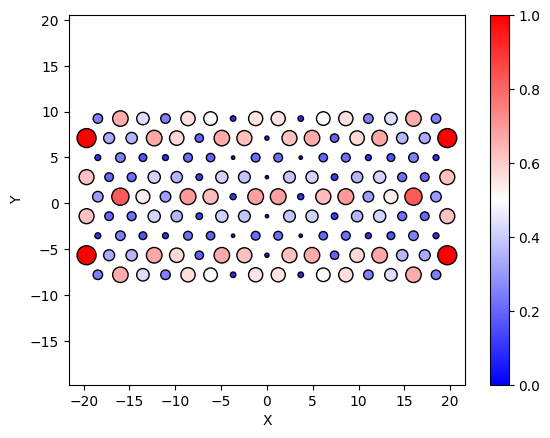

In [7]:
import jax.numpy as jnp
flake_topological = haldane_graphene.cut_flake(Rectangle(20, 20))
idx = jnp.argwhere(jnp.abs(flake_topological.energies) < 1e-1)[0].item()
flake_topological.show_2d( display = flake_topological.eigenvectors[:, idx], scale = True  )

## Modifying existing materials

You can copy the material you want to modify and change/overwrite its attributes.
As an example, we will turn our ordinary graphene model into a direction-independent variant of the Haldane model by introducing complex nnn hoppings and without the staggered onsite potential

In [8]:
from copy import deepcopy
graphene  = MaterialCatalog.get("graphene")
graphene_haldane_variant = deepcopy(graphene)
graphene_haldane_variant.add_interaction("hamiltonian", participants = ('pz', 'pz'), parameters = [0, 1.0, 1j*0.1])
print(graphene_haldane_variant)

Material: graphene
  Lattice Constant: 2.46 Å
  Lattice Basis: 
[[ 1.         0.         0.       ]
 [-0.5        0.8660254  0.       ]]
  Orbital Species:
    pz characterized by (n,l,m,s, atom name) = (0, 'C')
  Orbitals:
    Position: (0, 0), Tag: sublattice_1, Species: pz
    Position: (-0.3333333333333333, -0.6666666666666666), Tag: sublattice_2, Species: pz
  Interactions:
   Type: hamiltonian, Participants: ('pz', 'pz'):
                    NN Couplings: 0, 1.0, 0.1j
                    Other neighbors: 
    Returns a zero coupling constant as a complex number.

    Args:
        d (float): A parameter (typically representing distance or some other factor) that is ignored by the function, as the output is always zero.

    Returns:
        complex: Returns 0.0 as a complex number (0.0j).
    
   Type: coulomb, Participants: ('pz', 'pz'):
                    NN Couplings: 16.522, 8.64, 5.333
                    Other neighbors: Coupling with a (regularized) Coulomb-like potential

## Handling non-periodic dimensions

Say you want to have a custom ssh chain with 2 atoms in the unit cell, but displace one of the atoms in y-direction. You do this by including a second basis vector in y-direction and give the atom you want to displace a non-vanishing y-coordinate. To not get a 2D lattice, you have to specify explicitly which direction(s) you want to be periodically repeated.

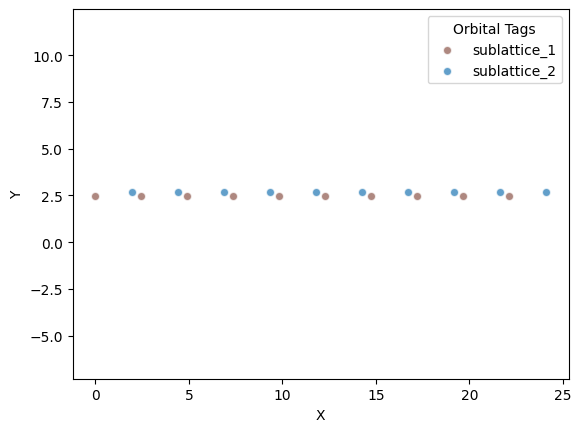

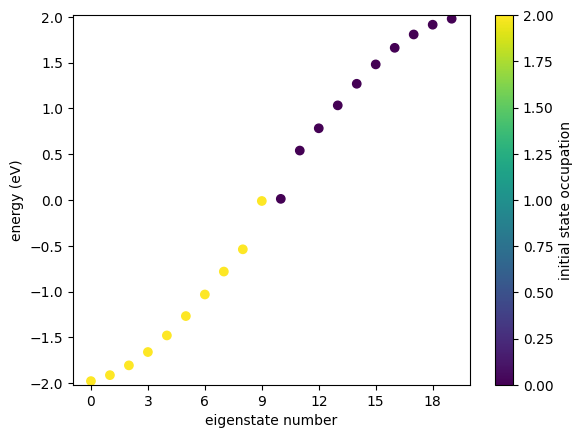

In [9]:
_ssh_modified = (
    Material("ssh")
    .lattice_constant(2.46)
    .lattice_basis([
        [1, 0, 0],
        [0, 1, 0],
    ],
    periodic = [0]) # THIS IS THE LINE    
    .add_orbital_species("pz", atom='C')
    .add_orbital(position=(0,0), tag="sublattice_1", species="pz")
    .add_orbital(position=(0.8,0.1), tag="sublattice_2", species="pz")
    .add_interaction(
        "hamiltonian",
        participants=("pz", "pz"),
        parameters=[0.0, 1 + 0.2, 1 - 0.2],
    )
    .add_interaction(
        "coulomb",
        participants=("pz", "pz"),
        parameters=[16.522, 8.64, 5.333],
        expression=lambda d: 14.399 / d + 0j
    )
)
flake = _ssh_modified.cut_flake( unit_cells = 10)
flake.show_2d()
flake.show_energies()